# Домашнее задание 7:

Зафиксируйте какую-либо многомерную скалярную функцию и реализуйте для неё анализ чувствительности по методу Соболя на Python с использованием библиотеки SALib.

1) Проведите анализ чувствительности, проверьте сходимость, измерьте тайминги  
2) Ускорьте вычисления Python с использованием любой из имеющихся возможностей (PyBind11, ctypes, cython, numba)  
3) Попробуйте добавить параллелизм в вычисления  
4) Оформите и представьте результаты  

In [1]:
import time
import os
import math
import multiprocessing as mp
import numba
import numpy as np

from SALib.sample import saltelli
from SALib.analyze import sobol

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
sns.set_style("whitegrid")
sns.set_palette("colorblind")
sns.set(
    rc={
        'figure.figsize': (12, 8),
    }
)


In [84]:
def make_sensitivity_analysis(problem, analysing_func, samples_num):
    #samples generation
    start = time.time()
    samples = saltelli.sample(cfg, samples_num)
    sampling_time = time.time() - start
    print("Sampling time:         {:10.4f}".format(sampling_time))

    # model evaluation
    y = np.zeros([samples.shape[0]])
    start = time.time()
    for i, x in enumerate(samples):
        y[i] = analysing_func(x)
    eval_time = time.time() - start
    print("Model evaluation time: {:10.4f}".format(eval_time))

    # sobol analyze
    start = time.time()
    sa_result = sobol.analyze(cfg, y, parallel=False, print_to_console=True)
    sa_time = time.time() - start
    print("Analysis time:         {:10.4f}".format(sa_time))

    return sa_result, sampling_time, eval_time, sa_time


def print_report(sa_result, sampling_time, eval_time, sa_time):
    print("Sampling time:         {:10.4f}".format(sampling_time))
    print("Model evaluation time: {:10.4f}".format(eval_time))
    print("Analysis time:         {:10.4f}".format(sa_time))

    sa_result.plot()

In [85]:
SAMPLES_NUM = 2 ** 20 # 1_000_000

1. Проведите анализ чувствительности, проверьте сходимость, измерьте тайминги:

In [86]:
def func_1(x):
    return (
        np.sin(x[0]) * (np.cos(x[2]) ** 3) +
        np.cos(x[1]) * (np.sin(x[1]) ** 2) +
        np.sin(x[2]) * (np.cos(x[0]) ** 4)
    )

cfg = {
    'num_vars': 3,
    'names': ['x0', 'x1', 'x2'],
    'bounds': [
        [-math.pi, math.pi],
        [-math.pi, math.pi],
        [-math.pi, math.pi]
    ]
}


Sampling time:            34.1898
Model evaluation time:    60.2298
          ST   ST_conf
x0  0.626374  0.001960
x1  0.175824  0.000460
x2  0.824178  0.001897
              S1   S1_conf
x0  4.303128e-07  0.001964
x1  1.758242e-01  0.001151
x2  1.978026e-01  0.002351
                    S2   S2_conf
(x0, x1) -2.472092e-06  0.002528
(x0, x2)  6.263732e-01  0.003342
(x1, x2)  6.100721e-09  0.001899
Analysis time:            49.7970


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

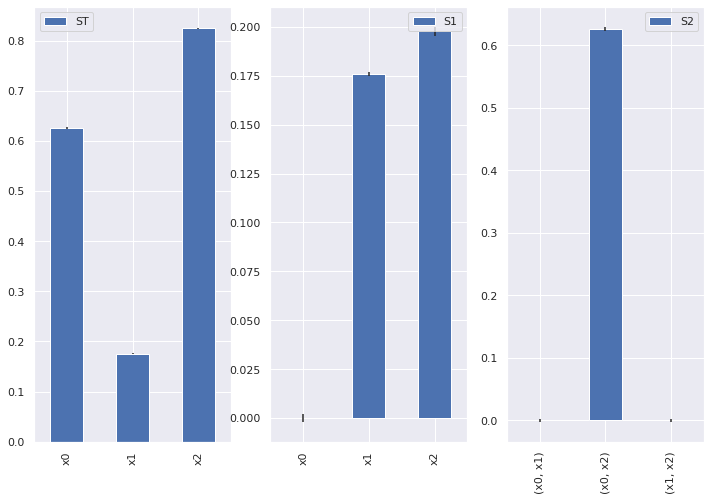

In [87]:
sa_result, sampling_time, eval_time_default, sa_time = \
    make_sensitivity_analysis(cfg, func_1, SAMPLES_NUM)

sa_result.plot()

2 Ускорьте вычисления Python с использованием любой из имеющихся возможностей (PyBind11, ctypes, cython, __numba__):

In [88]:
def evaluate_samples(cfg, analysing_func, samples_num):
    #samples generation
    start = time.time()
    samples = saltelli.sample(cfg, samples_num)
    sampling_time = time.time() - start
    print("Sampling time:         {:10.4f}".format(sampling_time))

    # model evaluation
    y = np.zeros([samples.shape[0]])
    start = time.time()
    for i, x in enumerate(samples):
        y[i] = analysing_func(x)
    eval_time = time.time() - start
    print("Model evaluation time: {:10.4f}".format(eval_time))
    
    return sampling_time, eval_time, (x, y)

In [89]:
@numba.njit
def func_2(x):
    return (
        np.sin(x[0]) * (np.cos(x[2]) ** 3) +
        np.cos(x[1]) * (np.sin(x[1]) ** 2) +
        np.sin(x[2]) * (np.cos(x[0]) ** 4)
    )

In [90]:
sampling_time, eval_time_numba, _ = evaluate_samples(cfg, func_2, SAMPLES_NUM)

Sampling time:            33.7859
Model evaluation time:     3.1585


3. Попробуйте добавить параллелизм в вычисления:

In [91]:
# parallelism via multithreading
def evaluate_samples_parallel(cfg, analysing_func, samples_num):
    #samples generation
    start = time.time()
    samples = saltelli.sample(cfg, samples_num)
    sampling_time = time.time() - start
    print("Sampling time:         {:10.4f}".format(sampling_time))
    
    num_procs = os.cpu_count()
    num_procs = 8
    
    # model evaluation
    y = np.zeros([samples.shape[0]])
    start = time.time()
    with mp.Pool(num_procs) as pool:
        y = pool.map(analysing_func, samples.tolist())
        
        
    eval_time = time.time() - start
    print("Model evaluation time: {:10.4f}".format(eval_time))
    
    return sampling_time, eval_time, (samples, y)

In [92]:
sampling_time, eval_time_df_mp, (x, y) = evaluate_samples_parallel(cfg, func_1, SAMPLES_NUM)

Sampling time:            34.9080
Model evaluation time:    15.9963


In [93]:
[(x, y, func_1(x)) for x, y in zip(x, y) if func_1(x) != y]

[]

In [94]:
# numba function with multiprocessing
sampling_time, eval_time_nf_mp, (x, y) = evaluate_samples_parallel(cfg, func_2, SAMPLES_NUM)

Sampling time:            33.7773


/home/alex/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'x' of function 'func_2'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-89-1be68fe84ecf>", line 2:
@numba.njit
def func_2(x):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/alex/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'x' of function 'func_2'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-89-1be68fe84ecf>", line 2:
@numba.n

Model evaluation time:    11.7635


Это несколько поломанный вариант - вероятно, можно было выжать больше, но мне не удалось починить.

In [95]:
# parallelism via  numba.prange
def evaluate_samples_numba_parallel(cfg, analysing_func, samples_num):
    #samples generation
    start = time.time()
    samples = saltelli.sample(cfg, samples_num)
    sampling_time = time.time() - start
    print("Sampling time:         {:10.4f}".format(sampling_time))
    
    num_procs = os.cpu_count()
    #num_procs = 8
    
    # model evaluation
    y = np.zeros([samples.shape[0]])
    start = time.time()
    for i in numba.prange(samples_num):
        y[i] = analysing_func(samples[i])
        
        
    eval_time = time.time() - start
    print("Model evaluation time: {:10.4f}".format(eval_time))
    
    return sampling_time, eval_time, (samples, y)

In [96]:
# default function with numba parallel
sampling_time, eval_time_df_np, (x, y) = evaluate_samples_numba_parallel(cfg, func_1, SAMPLES_NUM)

Sampling time:            34.3390
Model evaluation time:     7.6303


In [97]:
# numba function with numba parallel
sampling_time, eval_time_nf_np, (x, y) = evaluate_samples_numba_parallel(cfg, func_2, SAMPLES_NUM)

Sampling time:            34.4352
Model evaluation time:     0.4147


Оба варианта с  numba.prange быстрее multithreading!

# Вывод

In [98]:
print("evaluation time without optimisation:                             {:10.8f}".format(eval_time_default))
print("evaluation time for numba optimisation:                           {:10.8f}".format(eval_time_numba))
print("evaluation time for parallel by multiprocessing default function: {:10.8f}".format(eval_time_df_mp))
print("evaluation time for parallel by multiprocessing numba function:   {:10.8f}".format(eval_time_nf_mp))
print("evaluation time for parallel by numba.prange default function:    {:10.8f}".format(eval_time_df_np))
print("evaluation time for parallel by numba.prange numba function:      {:10.8f}".format(eval_time_nf_np))

evaluation time without optimisation:                             60.22982478
evaluation time for numba optimisation:                           3.15851569
evaluation time for parallel by multiprocessing default function: 15.99625802
evaluation time for parallel by multiprocessing numba function:   11.76346684
evaluation time for parallel by numba.prange default function:    7.63034749
evaluation time for parallel by numba.prange numba function:      0.41474485


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

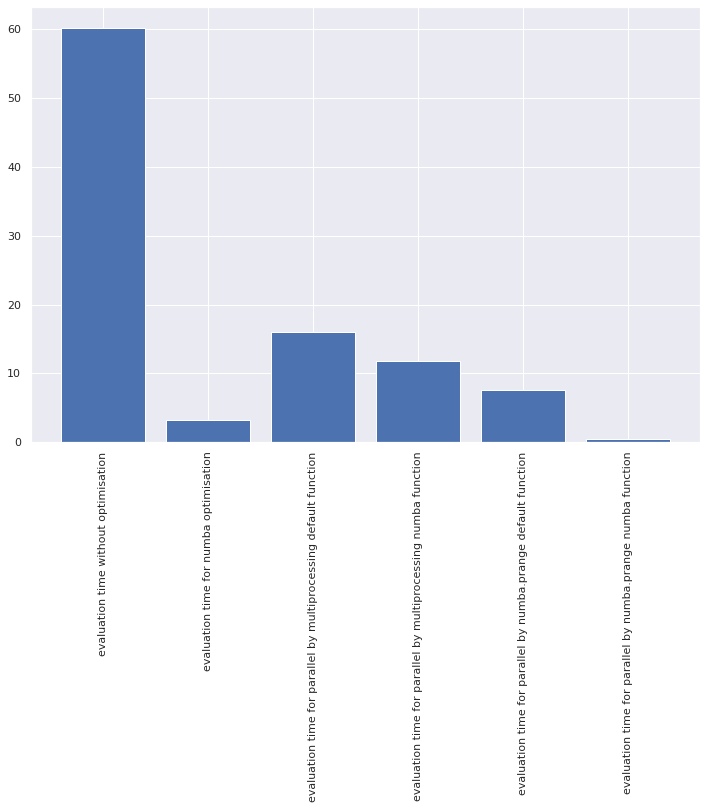

In [99]:
plt.bar(
    [
        "evaluation time without optimisation",
        "evaluation time for numba optimisation",
        "evaluation time for parallel by multiprocessing default function",
        "evaluation time for parallel by multiprocessing numba function",
        "evaluation time for parallel by numba.prange default function",
        "evaluation time for parallel by numba.prange numba function",
    ], [
        eval_time_default,
        eval_time_numba,
        eval_time_df_mp,
        eval_time_nf_mp,
        eval_time_df_np,
        eval_time_nf_np,
    ] 
)
plt.xticks(rotation=90)

Интересно, что использование просто numba оказалось быстрее любого multiprocessing - видимо из-за GIL и долгой передачи данных между процессами.